In [1]:
import numpy as np

In [102]:
class LinReg(object):
    
    def __init__(self,regularization=None, lam=1, alpha=0.001, beta_1=0.9, beta_2=0.999):
        ''' Linear regressor fit via Adaptive Momentum Stochastic Gradient Descent (ADAM).
            See here: https://arxiv.org/pdf/1412.6980.pdf
            ------------------------------------------------------------------------------------------------
            Parameters:
            regularization: None, L2, or L1 for ordinary least squares, ridge regression and LASSO resp.
                            Default None.
            lam: Regularization parameter lambda, controls weight of regularization parameter.
            alpha, beta_1 and beta_2: Tunable paramters of the ADAM algorithm, set to suggested defaults.
            ''' 
        self.lam = lam
        self.alpha, self.beta_1, self.beta_2 = alpha, beta_1, beta_2
        self.params = None
        self.domain_size = -1
        self.is_fit = False
        
        if regularization == 'L2' or regularization == 'L1':
            self.reg = True
            self.reg_type = regularization
        else:
            self.reg = False
    
    def fit(self, X, y):
        
        if type(X) != np.ndarray or type(y) != np.ndarray:
            print('Error: Please make sure data is entered as numpy d-array.')
            return
        
        N, p = X.shape[0], 1
        
        if len(X.shape) > 1:
            p = X.shape[1]
        
        self.domain_size = p
            
        if len(y.shape) > 1:
            print('Error: Please enter values as a 1-D array')
            return
        
        if N != y.shape[0]:
            print('Error: Data shapes do not match')
            return
        
        if p == 1 and self.reg == False:
            # Simple linear regression case will not use ADAM but the deterministic solution.
            # https://en.wikipedia.org/wiki/Simple_linear_regression#Fitting_the_regression_line
            
            X_m, y_m = X.mean(), y.mean()
            slope = ((X - X_m) * (y - y_m)).sum() / ((X - X_m)**2).sum()
            bias = y_m - (slope * X_m)
            self.params = np.array([bias,slope])
            self.is_fit = True
            return
        
        def grad(theta, X_i, y_i):
            g = np.zeros(p+1)
            X_b = np.append(np.array([1]),X_i)
            f = y_i - np.dot(theta,X_b)
            
            if self.reg == False:
                for j in range(p+1):
                    g[j] = -2 * X_b[j] * f
                return g
            
            elif self.reg_type == 'L2':
                for j in range(p+1):
                    g[j] = 2 *((-X_b[j] * f) + ((self.lam / N) * theta[j]))
                return g
            
            else:
                for j in range(p+1):
                    if theta[j] > 0:
                        l_1 = self.lam / N
                    elif theta[j]< 0:
                        l_1 = -self.lam / N
                    else:
                        l_1 = 0
                    
                    g[j] = (-2 * X_b[j] * f) + l_1
                return g
        
        # Now start ADAM
        
        nb_epochs = max(10000, N // 50)  # Fixed epoch size. In future may change to early stop based on hold-out.
        mini_batch_size = min(N,50)
        theta = np.zeros(p+1)
        m, v = np.zeros(p+1), np.zeros(p+1)
        
        for k in range(nb_epochs):
            I = np.random.choice(N,mini_batch_size,replace=False)
            
            g = np.zeros(p+1)
            for j in I:
                g = g + grad(theta,X[j],y[j])
                
            m = (self.beta_1 * m) + ((1-self.beta_1) * g)
            v = (self.beta_2 * v) + ((1 - self.beta_2) * (g**2))
            m_b = m / (1 - self.beta_1**(k+1))
            v_b = v / (1 - self.beta_2**(k+1))
            theta = theta - ((self.alpha * m_b) / (np.sqrt(v_b) + 1e-8))
        
        self.params = theta
        self.is_fit = True
        
        
        
    def predict(self, x):
        
        if self.is_fit == False:
            print('Error: The model has not yet been fit to the data')
            return
        
        elif len(x.shape) == 1 and self.domain_size != 1:
            print('Error: Data has incorrect number of parameters')
            return
        
        elif len(x.shape) > 1 and self.domain_size != x.shape[1]:
            print('Error: Data has incorrect number of parameters')
            return
        
        elif type(x) != np.ndarray:
            print('Error: Data must be a numpy array')
            return
        
        elif len(x.shape) == 1:
            y_b = np.zeros(x.shape[0])
            
            for k in range(x.shape[0]):
                x_b = np.array([1,x[k]])
                y_b[k] = np.dot(x_b,self.params)
            return y_b
        
        else:
            y_b = np.zeros(x.shape[0])
            
            for k in range(x.shape[0]):
                x_b = np.append(np.array([1]),x[k])
                y_b[k] = np.dot(x_b,self.params)
            return y_b      

In [92]:
# Testing regressor on 1-D data set.

X_1 = np.arange(0,100,3)
E = 20 * np.random.randn(34)
y_1 = 2 * X_1 + 34 + E


reg = LinReg()

reg.fit(X_1,y_1)

In [58]:
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

In [109]:
reg2 = LinReg(regularization='L2',lam=0)
reg2.fit(X_1,y_1)

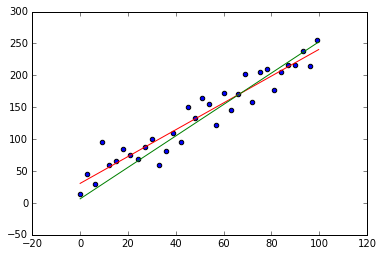

In [110]:
plt.scatter(X_1,y_1)
dom = np.arange(0,100,0.25)
plt.plot(dom,reg.predict(dom), color='red')
plt.plot(dom,reg2.predict(dom), color='green')